Import

In [ ]:
import sys

sys.path.append("../")
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import re
import cv2
import json
from pprint import pprint
import random

Helper Functions

In [ ]:
def extract_id(file_name: str) -> str | None:
    """
    Give a file name such as 'A_P000001_PAS_CPG.tif',
    Extract the file ID: 'A_P000001' using regular expression
    """
    match = re.match(r"([A-Z]_P\d+)_", file_name, re.IGNORECASE)

    if match:
        return match.group(1)
    else:
        return None


def cell_mask_to_rgb(cell_mask: np.ndarray) -> np.ndarray:
    """For visualization purposes
    Convert 2D cell mask to an RGB image
    2D cell mask:
    1 - Lympchoyte centroids
    2 - Monocytes centroids
    RGB image:
    Green - Lympchoyte centroids
    Blue - Monocytes centroids
    """
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13, 13))
    cell_mask = cv2.dilate(cell_mask, kernel, iterations=1)
    rgb_mask = np.zeros(
        (cell_mask.shape[0], cell_mask.shape[1], 3), dtype=np.uint8
    )
    rgb_mask[cell_mask == 1] = (0, 255, 0)
    rgb_mask[cell_mask == 2] = (0, 0, 255)
    return rgb_mask

Visualize 50 random patches

In [ ]:
# Specify data folders

# Folder containing image patches
patch_image_dir = "/home/u1910100/Documents/Monkey/patches_256/images"
# Folder containing cell masks
cell_mask_dir = (
    "/home/u1910100/Documents/Monkey/patches_256/annotations/masks"
)
# Folder containing json files
json_dir = (
    "/home/u1910100/Documents/Monkey/patches_256/annotations/json"
)


# Visualize 50 random patches
file_names = os.listdir(patch_image_dir)
files_sample = random.sample(file_names, 50)

for name in files_sample:
    name_without_ext = os.path.splitext(name)[0]

    # Get path to files
    patch_image_path = os.path.join(
        patch_image_dir, f"{name_without_ext}.npy"
    )
    cell_mask_path = os.path.join(
        cell_mask_dir, f"{name_without_ext}.npy"
    )
    json_path = os.path.join(json_dir, f"{name_without_ext}.json")

    # load RGB patch and cell mask
    image_patch = np.load(patch_image_path)
    cell_mask = np.load(cell_mask_path)
    # Convert cell mask to RGB image for visualization
    rgb_cell_mask = cell_mask_to_rgb(cell_mask)

    # load json file
    annotations = {}
    with open(json_path, "r") as file:
        annotations = json.load(file)

    # Output
    pprint(name)
    # pprint(annotations)
    fig, axes = plt.subplots(1, 3, figsize=(17, 17))
    axes[0].imshow(image_patch)
    axes[0].title.set_text("RGB Patch")
    axes[1].imshow(rgb_cell_mask)
    axes[1].title.set_text("Cell Mask")
    axes[2].imshow(image_patch, alpha=0.5)
    axes[2].imshow(rgb_cell_mask, alpha=0.5)
    axes[2].title.set_text("Cell Mask overlay on RGB Patch")
    plt.show()

Count cells

In [ ]:
# Folder containing json files
json_dir = (
    "/home/u1910100/Documents/Monkey/patches_256/annotations/json"
)
file_names = os.listdir(json_dir)

lymphocyte_count = 0
monocytes_count = 0

for name in file_names:
    json_path = os.path.join(json_dir, name)
    annotations = {}
    with open(json_path, "r") as file:
        annotations = json.load(file)

    lymph_coords = annotations["lymphocytes"]
    mono_coords = annotations["monocytes"]

    lymphocyte_count += len(lymph_coords)
    monocytes_count += len(mono_coords)


print(f"lympho count = {lymphocyte_count}")
print(f"mono count = {monocytes_count}")

In [ ]:
# Create patch stats
json_dir = (
    "/home/u1910100/Documents/Monkey/patches_256/annotations/json"
)

stats_save_path = (
    "/home/u1910100/Documents/Monkey/patches_256/patch_stats.json"
)

patch_stats = {}

p = 0
n = 0

file_names = os.listdir(json_dir)
for name in file_names:
    name_without_ext = os.path.splitext(name)[0]
    json_path = os.path.join(json_dir, name)
    annotations = {}
    with open(json_path, "r") as file:
        annotations = json.load(file)

    lymph_coords = annotations["lymphocytes"]
    mono_coords = annotations["monocytes"]

    patch_stats[name_without_ext] = {
        "lymph_count": len(lymph_coords),
        "mono_count": len(mono_coords),
    }

    if len(lymph_coords) > 0 or len(mono_coords) > 0:
        p += 1
    else:
        n += 1

print(p)
print(n)
with open(stats_save_path, "w") as file:
    json.dump(patch_stats, file)

Visualize Detection Dataloader

In [1]:
%reset -f
import sys

sys.path.append("../")
from monkey.data.dataset import get_detection_dataloaders
from monkey.data.data_utils import imagenet_denormalise
from monkey.config import TrainingIOConfig
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

use_nuclick_masks = True
batch_size = 8
module = "multiclass_detection"

IOconfig = TrainingIOConfig(
    dataset_dir="/home/u1910100/Documents/Monkey/patches_256",
    save_dir="./",
)
if use_nuclick_masks:
    IOconfig.set_mask_dir(
        "/home/u1910100/Documents/Monkey/patches_256/annotations/nuclick_masks_processed"
    )


train_loader, val_loader = get_detection_dataloaders(
    IOconfig,
    val_fold=5,
    task=1,
    batch_size=batch_size,
    disk_radius=15,
    do_augmentation=True,
    module=module,
    use_nuclick_masks=use_nuclick_masks,
    include_background_channel=False,
)

/home/u1910100/miniconda3/envs/tiatoolbox/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2339, 1518, 1678, 5869]
train patches: 11404
test patches: 2911


In [2]:
def binary_to_rgb(binary_mask):
    rgb = np.zeros(
        (binary_mask.shape[0], binary_mask.shape[1], 3),
        dtype=np.uint8,
    )
    rgb[:, :, 0] = binary_mask * 255
    rgb[:, :, 1] = binary_mask * 255
    rgb[:, :, 2] = binary_mask * 255
    return rgb

multiclass_detection
['A_P000017_78400_114016_78656_114272', 'D_P000003_21952_4928_22208_5184', 'D_P000011_35168_55328_35424_55584', 'B_P000005_44800_137760_45056_138016', 'D_P000013_31360_7616_31616_7872', 'A_P000017_71232_105504_71488_105760', 'A_P000021_64512_113568_64768_113824', 'B_P000005_29344_86016_29600_86272']


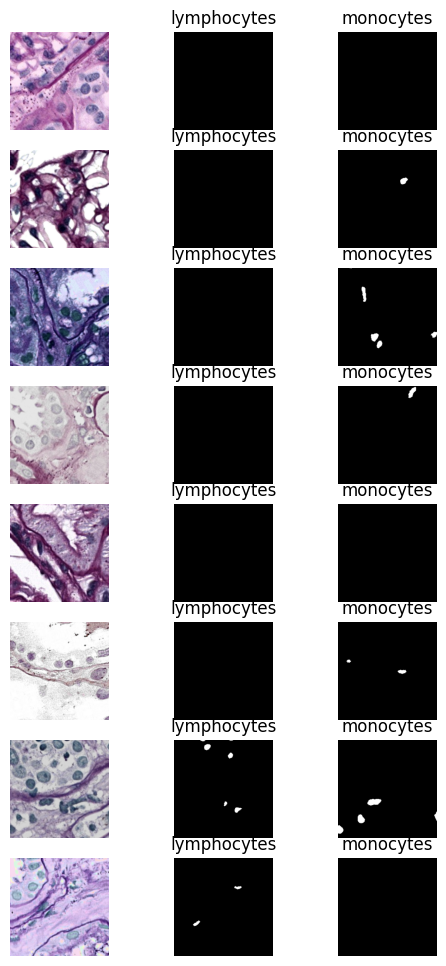

In [8]:
data = next(iter(train_loader))
print(module)
print(data['id'])
fig, axes = plt.subplots(batch_size, 3, figsize=(6,12))

for i in range(batch_size):
    image = data["image"][i].numpy()
    image = np.moveaxis(image, 0, 2)
    image = imagenet_denormalise(image)
    axes[i][0].imshow(image)

    if module == "detection":
        mask = data["mask"][i][0].numpy()
        axes[i][1].imshow(mask, cmap="gray")
        axes[i][2].imshow(image, alpha=0.5)
        axes[i][2].imshow(mask, alpha=0.5)

    if module == "multiclass_detection":

        mask = data["mask"][i].numpy()
        axes[i][1].imshow(binary_to_rgb(mask[0]))
        axes[i][1].set_title("lymphocytes")
        axes[i][2].imshow(binary_to_rgb(mask[1]))
        axes[i][2].set_title("monocytes")

        for ax in axes.ravel():
            ax.axis('off')

plt.show()

Visualize Classification DataLoader

In [ ]:
%reset -f
import sys

sys.path.append("../")
from monkey.data.dataset import get_classification_dataloaders
from monkey.data.data_utils import imagenet_denormalise
from monkey.config import TrainingIOConfig
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import os

IOconfig = TrainingIOConfig(
    dataset_dir="/home/u1910100/Documents/Monkey/classification",
    save_dir="./",
)
IOconfig.set_image_dir(
    "/home/u1910100/Documents/Monkey/classification/patches"
)
IOconfig.set_mask_dir(
    "/home/u1910100/Documents/Monkey/classification/patches"
)
batch_size = 2
train_loader, val_loader = get_classification_dataloaders(
    IOconfig,
    val_fold=1,
    batch_size=batch_size,
    do_augmentation=True,
)

In [ ]:
data = next(iter(val_loader))
fig, axes = plt.subplots(batch_size, 2, figsize=(8, 8))

for i in range(batch_size):
    print(data["id"][i])
    print(data["label"][i])
    # print(data["label"].shape)
    # break
    image = data["image"][i].numpy()
    mask = data["mask"][i][0].numpy()

    image = np.moveaxis(image, 0, 2)
    image = imagenet_denormalise(image)

    axes[i][0].imshow(image)
    axes[i][1].imshow(mask, cmap="gray")
plt.show()

Visualize NuClick Masks Processed

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random


nuclick_dir = "/home/u1910100/Documents/Monkey/patches_256/annotations/nuclick_masks_processed"
files = os.listdir(nuclick_dir)
random.shuffle(files)


def binary_to_color(mask):
    rgb = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    rgb[:, :, 0] = np.where(mask == 1, 255, 0)
    rgb[:, :, 1] = np.where(mask == 2, 255, 0)
    return rgb


i = 0
for fn in files:
    print(fn)
    data_path = os.path.join(nuclick_dir, fn)
    data = np.load(data_path)

    image = data[:, :, 0:3]
    binary_mask = data[:, :, 3]
    class_mask = data[:, :, 4]
    contour = data[:, :, 5]

    class_mask_rgb = binary_to_color(class_mask)

    fix, axes = plt.subplots(2, 2, figsize=(14, 12))

    axes[0][0].imshow(binary_mask, cmap="gray")
    axes[0][0].set_title("binary_mask")
    axes[0][1].imshow(contour, cmap="gray")
    axes[0][1].set_title("Contour")
    axes[1][1].imshow(class_mask_rgb)
    axes[1][1].set_title("class map")

    axes[1][0].imshow(image)
    axes[1][0].set_title("RGB")

    plt.show()

    i += 1
    if i > 5:
        break